# __Capstone Project 2. Toxic Comment Classification Challenge__

Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive.

## 1. Data Exploration

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

In [2]:
import matplotlib.pyplot as plt

Loading the data files

In [3]:
train= pd.read_csv('cs2train.csv')
test= pd.read_csv('cs2test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Check whether the dataframe has any missing values

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

There are no missing values for in the training and test set.

In [7]:
list_classes=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y1=train['toxic']
y2=train['severe_toxic']
y3=train['obscene']
y4=train['threat']
y5=train['insult']
y6=train['identity_hate']
x_train= train['comment_text']
x_test= test['comment_text']

In [8]:
y_train=train[list_classes]

In [9]:
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
y_train.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


In [11]:
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import nltk
#nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [12]:
df_toxic = train.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5,0,'category')

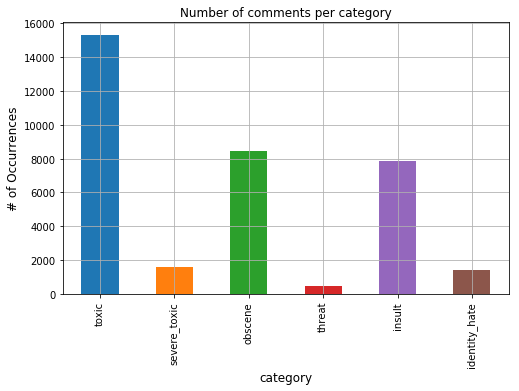

In [13]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

How many comments have multi labels?

Text(0.5,0,'# of categories')

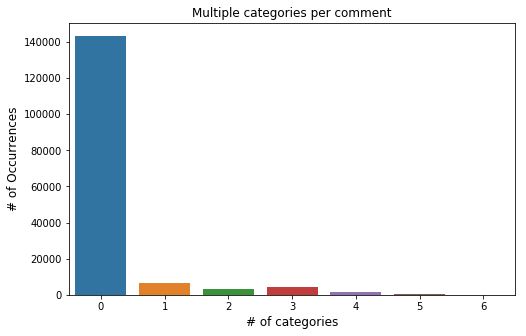

In [14]:
rowsums = train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Percentage of comments that are not labelled

In [15]:
print('Percentage of comments that are not labelled:')
print(len(train[(train['toxic']==0) & (train['severe_toxic']==0) & (train['obscene']==0) & (train['threat']== 0) & (train['insult']==0) & (train['identity_hate']==0)]) / len(train))

Percentage of comments that are not labelled:
0.8983211235124177


The distribution of the number of words in comment texts

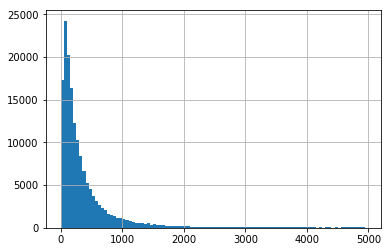

In [16]:
lens = train.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

## __2. Data Preprocessing__

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [18]:
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
train['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

Split the current training set into training set and test set

In [19]:
train2, test2 = train_test_split(train, random_state=42, test_size=0.33, shuffle=True)
x_train2 = train2.comment_text
x_test2 = test2.comment_text

## __3. Machine Learning Techniques__

1) Naive Bayes

In [20]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
categories = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(x_train2, train2[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(x_test2)
    print('Test accuracy is {}'.format(accuracy_score(test2[category], prediction)))

... Processing toxic
Test accuracy is 0.9193300290548624
... Processing severe_toxic
Test accuracy is 0.9899922140564765
... Processing obscene
Test accuracy is 0.9516132095178412
... Processing threat
Test accuracy is 0.9971324939706413
... Processing insult
Test accuracy is 0.9517461402609241
... Processing identity_hate
Test accuracy is 0.9910366698949847


In [21]:
for category in categories:
    
    NB_pipeline.fit(x_train, y1)
    # compute the testing accuracy
    predictiony1 = pd.DataFrame(NB_pipeline.predict(x_test))
    NB_pipeline.fit(x_train, y2)
    # compute the testing accuracy
    predictiony2 = pd.DataFrame(NB_pipeline.predict(x_test))
    NB_pipeline.fit(x_train, y3)
    # compute the testing accuracy
    predictiony3 = pd.DataFrame(NB_pipeline.predict(x_test))
    NB_pipeline.fit(x_train, y4)
    # compute the testing accuracy
    predictiony4 = pd.DataFrame(NB_pipeline.predict(x_test))
    NB_pipeline.fit(x_train, y5)
    # compute the testing accuracy
    predictiony5 = pd.DataFrame(NB_pipeline.predict(x_test))
    NB_pipeline.fit(x_train, y6)
    # compute the testing accuracy
    predictiony6 = pd.DataFrame(NB_pipeline.predict(x_test))

In [22]:
predictionNB= pd.concat([x_test, predictiony1,predictiony2,predictiony3,predictiony4,predictiony5,predictiony6], axis=1, join='outer', keys=['comments', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [23]:
predictionNB.head()

,comments,toxic,severe_toxic,obscene,threat,insult,identity_hate
,comment_text,0,0,0,0,0,0
0,Yo bitch Ja Rule is more succesful then you'll...,1,0,0,0,0,0
1,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,I don't anonymously edit articles at all.,0,0,0,0,0,0


2) LinearSVC

In [24]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(x_train2, train2[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(x_test2)
    print('Test accuracy is {}'.format(accuracy_score(test2[category], prediction)))

... Processing toxic
Test accuracy is 0.959930876013597
... Processing severe_toxic
Test accuracy is 0.9906378776657362
... Processing obscene
Test accuracy is 0.9788830019559809
... Processing threat
Test accuracy is 0.9974553257752711
... Processing insult
Test accuracy is 0.9714009001310318
... Processing identity_hate
Test accuracy is 0.9919861752027194


In [35]:
for category in categories:
    
    SVC_pipeline.fit(x_train, y1)
    # compute the testing accuracy
    SVCpredictiony1 = pd.DataFrame(SVC_pipeline.predict(x_test))
    SVC_pipeline.fit(x_train, y2)
    # compute the testing accuracy
    SVCpredictiony2 = pd.DataFrame(SVC_pipeline.predict(x_test))
    SVC_pipeline.fit(x_train, y3)
    # compute the testing accuracy
    SVCpredictiony3 = pd.DataFrame(SVC_pipeline.predict(x_test))
    SVC_pipeline.fit(x_train, y4)
    # compute the testing accuracy
    SVCpredictiony4 = pd.DataFrame(SVC_pipeline.predict(x_test))
    SVC_pipeline.fit(x_train, y5)
    # compute the testing accuracy
    SVCpredictiony5 = pd.DataFrame(SVC_pipeline.predict(x_test))
    SVC_pipeline.fit(x_train, y6)
    # compute the testing accuracy
    SVCpredictiony6 = pd.DataFrame(SVC_pipeline.predict(x_test))

In [36]:
predictionSVC= pd.concat([x_test, SVCpredictiony1,SVCpredictiony2,SVCpredictiony3,SVCpredictiony4,SVCpredictiony5,SVCpredictiony6], axis=1, join='outer', keys=['comments', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [27]:
predictionSVC.head()

,comments,toxic,severe_toxic,obscene,threat,insult,identity_hate
,comment_text,0,0,0,0,0,0
0,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0
1,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,I don't anonymously edit articles at all.,0,0,0,0,0,0


3) Logistic Regression

In [28]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(x_train2, train2[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(x_test2)
    print('Test accuracy is {}'.format(accuracy_score(test2[category], prediction)))

... Processing toxic
Test accuracy is 0.9549364780949126
... Processing severe_toxic
Test accuracy is 0.9910556600011394
... Processing obscene
Test accuracy is 0.9761104464573956
... Processing threat
Test accuracy is 0.9973603752444976
... Processing insult
Test accuracy is 0.9687612753755294
... Processing identity_hate
Test accuracy is 0.991758293928863


In [29]:
for category in categories:
    
    LogReg_pipeline.fit(x_train, y1)
    # compute the testing accuracy
    LogRegpredictiony1 = pd.DataFrame(LogReg_pipeline.predict(x_test))
    LogReg_pipeline.fit(x_train, y2)
    # compute the testing accuracy
    LogRegpredictiony2 = pd.DataFrame(LogReg_pipeline.predict(x_test))
    LogReg_pipeline.fit(x_train, y3)
    # compute the testing accuracy
    LogRegpredictiony3 = pd.DataFrame(LogReg_pipeline.predict(x_test))
    LogReg_pipeline.fit(x_train, y4)
    # compute the testing accuracy
    LogRegpredictiony4 = pd.DataFrame(LogReg_pipeline.predict(x_test))
    LogReg_pipeline.fit(x_train, y5)
    # compute the testing accuracy
    LogRegpredictiony5 = pd.DataFrame(LogReg_pipeline.predict(x_test))
    LogReg_pipeline.fit(x_train, y6)
    # compute the testing accuracy
    LogRegpredictiony6 = pd.DataFrame(LogReg_pipeline.predict(x_test))

In [30]:
predictionLR= pd.concat([x_test, LogRegpredictiony1,LogRegpredictiony2,LogRegpredictiony3,LogRegpredictiony4,LogRegpredictiony5,LogRegpredictiony6], axis=1, join='outer', keys=['comments', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

In [31]:
predictionLR.head()

,comments,toxic,severe_toxic,obscene,threat,insult,identity_hate
,comment_text,0,0,0,0,0,0
0,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0
1,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0
3,":If you have a look back at the source, the in...",0,0,0,0,0,0
4,I don't anonymously edit articles at all.,0,0,0,0,0,0
